# Threshold Finding

In [1]:
from pathlib import Path
DATA = DATA = Path('/home/paperspace/ssdd')

BS = 18
EPOCHS = 1

In [2]:
import torch
from torch.jit import load

import segmentation_models_pytorch as smp

import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler

from matplotlib import pyplot as plt

from albumentations import (HorizontalFlip, RGBShift, ElasticTransform, GridDistortion,RandomBrightness ,ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

from onecyclelr import OneCycleLR

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from fastai.vision import *


In [3]:
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
def mask2rle(img):
    '''
    Numpy image to run length encoding
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [5]:
import fastai

class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image'] # 1x256x1600
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)
        


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
                ShiftScaleRotate(scale_limit=0, rotate_limit=0),
                ElasticTransform(),
                GridDistortion(), 
                RandomBrightness(),
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    mean=None,
    std=None,
    batch_size=BS,
    num_workers=8,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    ds  =SteelDataset(df, data_folder, mean,std, "val")
    dl = DataLoader(ds,batch_size = BS,num_workers=num_workers,shuffle=False)

    return dl


dataloader = provider(
    data_folder=DATA,
                df_path=DATA/"train.csv",
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=BS,
                num_workers=8,
)


In [6]:
model = load("jit_effb6_e70.pth")
model = model.eval().cuda()

def metricSeg(prob, tru,  reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    prob = torch.sigmoid(prob)
    batch_size = len(tru)
    result = dict()
    with torch.no_grad():
        for i in range(4):
            dice_ = []
            dice_neg_ = []
            dice_pos_ = []
            num_neg_ = []
            num_pos_ = []
            for mark in range(100):
                threshold = float(mark+1)/100.
                probability = prob[:,i:i+1,...]
                truth = tru[:,i:i+1,...]
                probability = probability.view(batch_size,  -1)
                truth = truth.view(batch_size,-1)
                assert(probability.shape == truth.shape)

                p = (probability > threshold).float()
                t = (truth > threshold).float()

                t_sum = t.sum(-1)
                p_sum = p.sum(-1)
                neg_index = torch.nonzero(t_sum == 0)
                pos_index = torch.nonzero(t_sum >= 1)

                dice_neg = (p_sum == 0).float()
                dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

                dice_neg = dice_neg[neg_index]
                dice_pos = dice_pos[pos_index]
                dice = torch.cat([dice_pos, dice_neg])

                dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
                dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
                dice = dice.mean().item()

                num_neg = len(neg_index)
                num_pos = len(pos_index)
                
                dice_.append(dice)
                dice_pos_.append(dice_pos)
                dice_neg_.append(dice_neg)
                num_pos_.append(num_pos)
                num_neg_.append(num_neg)
            result.update({
                "dice_%s"%(i+1):np.array(dice_),
                "dice_neg_%s"%(i+1):np.array(dice_neg_),
                "num_neg_%s"%(i+1):np.array(num_neg_),
                "num_pos_%s"%(i+1):np.array(num_pos_),
            })

    return result



#### Testing Metric 

In [7]:
cols = pd.DataFrame(metricSeg(torch.rand(2,4,256,1600).cuda(),(torch.rand(2,4,256,1600)>0.9).float().cuda())).columns
cols

Index(['dice_1', 'dice_neg_1', 'num_neg_1', 'num_pos_1', 'dice_2',
       'dice_neg_2', 'num_neg_2', 'num_pos_2', 'dice_3', 'dice_neg_3',
       'num_neg_3', 'num_pos_3', 'dice_4', 'dice_neg_4', 'num_neg_4',
       'num_pos_4'],
      dtype='object')

### Prediction & Score with different threshold

In [8]:
from tqdm import tqdm_notebook as tqdm

In [9]:
gen = iter(dataloader)
scores = []
for i in tqdm(range(len(dataloader))):
    with torch.no_grad(): # to save GPU mem
        img,mask = next(gen)
        img = img.cuda()
        mask = mask.cuda()
        pred = model(img)
        scores.append(pd.DataFrame(metricSeg(pred,mask)).values)

In [10]:
np.stack(scores).shape

(699, 100, 16)

In [11]:
finaldf = pd.DataFrame(np.stack(scores).mean(axis=0),columns=cols)

In [14]:
dices = finaldf[list("dice_%s"%(i+1) for i in range(4))]

In [16]:
from matplotlib import pyplot as plt

dice_1
dice_2
dice_3
dice_4


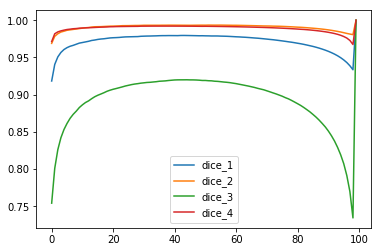

In [20]:
for d in dices:
    print(d)
    plt.plot(dices[d], )
plt.legend(dices.columns)

In [24]:
dices[30:60]

,dice_1,dice_2,dice_3,dice_4
30,0.978583,0.993242,0.915862,0.992036
31,0.978730,0.993250,0.916353,0.992059
32,0.978790,0.993252,0.916555,0.992080
33,0.978913,0.993253,0.916985,0.992097
34,0.979025,0.993256,0.917370,0.992108
35,0.979211,0.993254,0.917961,0.992112
36,0.979303,0.993327,0.918203,0.992116
37,0.979310,0.993321,0.918484,0.992117
38,0.979387,0.993390,0.918974,0.992113
39,0.979372,0.993375,0.919350,0.992106


In [25]:
[0.44,0.5,0.45,0.38]

[0.44, 0.5, 0.45, 0.38]